# CNN Image Classfier: Human Facial Eexpression Recognition

The goal of this project is to build a model that recognizes human facial expressions using FER-2013 dataset.
The reported human accuracy is reprted in [1] to be 68±5% so I will use this as the Bayes rate.
[1] "Challenges in Representation Learning: A report on three machine learning contests", Ian J. Goodfellow et. al.

# Data handling

We will first download, explore, transform, and split the data in preparation for next steps

In [67]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import time
import pickle

In [13]:
# load the data
data = pd.read_csv('data/icml_face_data.csv')
# create emotions map (provded by the data source)
emotions_map = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

In [10]:
# quick checks
print(data.info())
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...


In [12]:
# check the categories in Usage columns
print(data[' Usage'].unique())

['Training' 'PublicTest' 'PrivateTest']
[0 2 4 6 3 5 1]


The data contains 'Training' set to train the model, 'PublicTest' set is for validation, and finally
I will test the model with 'PrivateTest' set.

In all the data, 'pixles' contain a string format vector of all the 48*48 pixles of the greyscale image.
So we will first concert the pixles into 2D image arrays.
And then we will split the data into train, dev, and test sets

In [14]:
# a fucntion to convert pixles into 2D arrays
def convert_pixles_to_2d_array(pixels):
    return np.array([int(x) for x in pixels.split()]).reshape(48,48,1)

In [17]:
# create a new column "image" containing the arrays of converted pixels
data['image'] = data[' pixels'].apply(convert_pixles_to_2d_array)

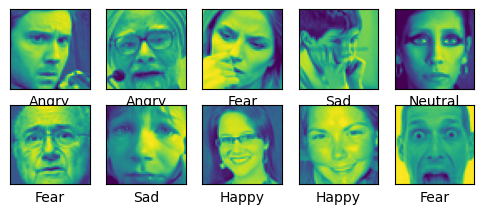

In [25]:
# visulaize some of the data for sanity check
plt.figure(figsize=(6,6))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.imshow(data['image'][i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(emotions_map[data['emotion'][i]])
plt.show()

In [30]:
# split the data 
train = data[data[' Usage']=='Training']
dev = data[data[' Usage']=='PublicTest']
test = data[data[' Usage']=='PrivateTest']

Now we will check the distribution of emotions in the training set to make sure the date is balanced. Otherwise, the model will be biased againsed less represented categories.

In [42]:
train['emotion'].value_counts().sort_index()

emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64

Clearly, the data are not balanced. For exampl, category 1 (Anger) is far below the rest.
To fix this, we will augment the data by generateing random transformation of the orginal set of each emotion
Untill evey emotion has $\approx 10,000$ example.

In [37]:
# first isolate the images for each emotion
data_per_emotion={}
for emotion in range(7):
    X_emo = train['image'][train['emotion']==emotion].values
    y_emo = train['emotion'][train['emotion']==emotion].values
    data_per_emotion[emotions_map[emotion]]=(X_emo,y_emo)

# create a random transformation generator
datagen = ImageDataGenerator(
    rotation_range=20,           # Random rotation between -20 to 20 degrees
    width_shift_range=0.2,       # Random horizontal shift
    height_shift_range=0.2,      # Random vertical shift
    shear_range=0.2,             # Random shearing
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest'          # Fill mode for pixels outside the boundaries
)

# fix the imbalance by adding transofrmed images of each categroy until there is around 10000 images per each
data_per_emotion_augmented={}
n = 10000 # number of examples per emotion required (complement all emotions to this level)
for emotion, X_y_original in data_per_emotion.items():
    X_emo =list(X_y_original[0])
    y_emo =list(X_y_original[1]) 
    X_emo_aug = X_emo.copy()
    y_emo_aug = y_emo.copy()
    m = len(X_emo)       # Original size of X
    
    # Reshape X to match the expected input shape (if necessary)
    X_emo = np.array(X_emo).reshape((m, 48, 48, 1))  # Example: reshaping for 48x48 grayscale images
    # y_emo = np.array(y_emo).reshape((-1,1))
    # Augment and append images until X_aug has n images
    while len(X_emo_aug) < n:
        # Generate batches of augmented images
        for batch in datagen.flow(X_emo, y_emo, batch_size=1000):
            X_emo_aug.extend(batch[0])
            y_emo_aug.extend(batch[1])
            if len(X_emo_aug) >= n:
                break
    data_per_emotion_augmented[emotion]=(X_emo_aug,y_emo_aug)
    print(f"completed augmention of {emotion} with length {len(X_emo_aug),len(y_emo_aug)}")
    
# concatenate and shuffle the data into a single train set a gain 
X_aug=[]
y_aug=[]
for emotion, (X_emo,y_emo) in data_per_emotion_augmented.items():
    X_aug.extend(X_emo)
    y_aug.extend(y_emo)
    
combined = list(zip(X_aug,y_aug))

np.random.shuffle(combined)

X_aug_shuffled, y_aug_shuffled = zip(*combined)

X_train = np.array(X_aug_shuffled)
y_train = np.array(y_aug_shuffled)


completed augmention of Angry with length (10990, 10990)
completed augmention of Disgust with length (10028, 10028)
completed augmention of Fear with length (10194, 10194)
completed augmention of Happy with length (10215, 10215)
completed augmention of Sad with length (10660, 10660)
completed augmention of Surprise with length (10513, 10513)
completed augmention of Neutral with length (10930, 10930)


In [50]:
# create the data array for dev and test sets
X_dev = np.stack(dev['image'].values)
y_dev = np.stack(dev['emotion'].values)
X_test = np.stack(test['image'].values)
y_test = np.stack(test['emotion'].values)

In [51]:
# checkshapes of all the data
for x in [X_train,y_train,X_dev,y_dev,X_test,y_test]:
    print(x.shape)
    

(73530, 48, 48, 1)
(73530,)
(3589, 48, 48, 1)
(3589,)
(3589, 48, 48, 1)
(3589,)


One last sanity check, plot labled ranom images from each set 

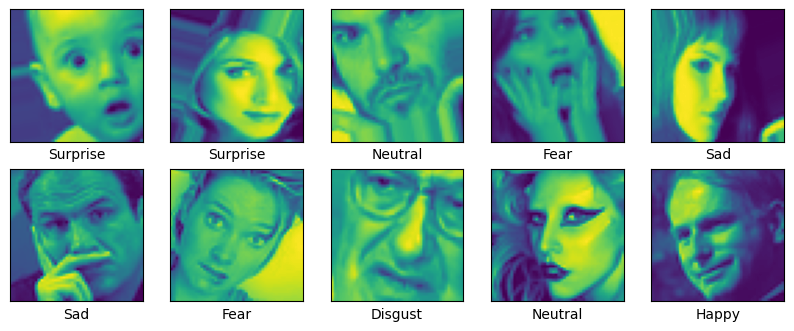

In [64]:
# visulaize some of the data for sanity check

#training set
plt.figure(figsize=(10,10))
for i in range(10):
    j = np.random.randint(0,len(X_train))
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[j])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f'{emotions_map[y_train[j]]}')
plt.show()

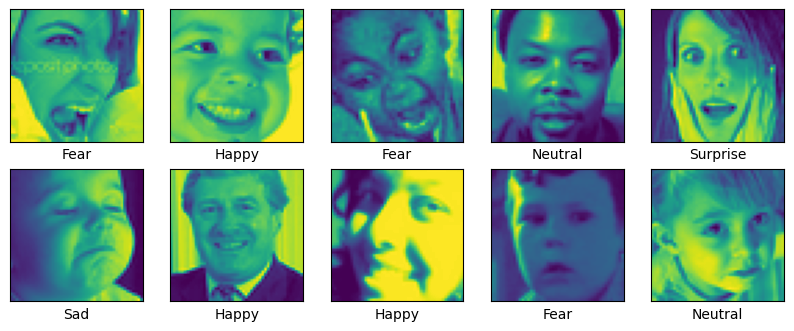

In [65]:
#training set
plt.figure(figsize=(10,10))
for i in range(10):
    j = np.random.randint(0,len(X_dev))
    plt.subplot(5,5,i+1)
    plt.imshow(X_dev[j])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f'{emotions_map[y_dev[j]]}')
plt.show()

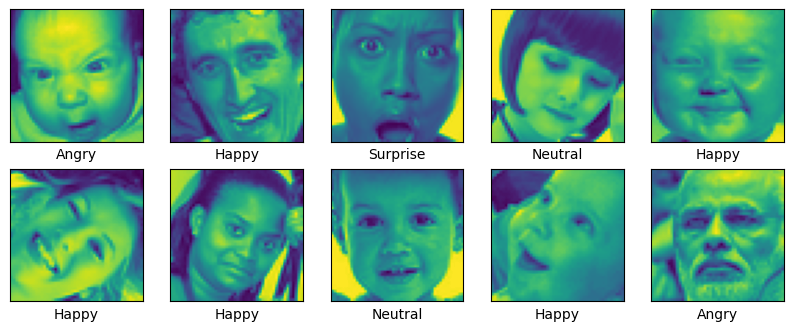

In [66]:
#training set
plt.figure(figsize=(10,10))
for i in range(10):
    j = np.random.randint(0,len(X_test))
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[j])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f'{emotions_map[y_test[j]]}')
plt.show()

It looks like every think is working fine and the data are aready to for use.
Save the prepared data in pickled format 

In [68]:
# Create a dictionary to hold the datasets
prepared_data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_dev': X_dev,
    'y_dev': y_dev,
    'X_test': X_test,
    'y_test': y_test
}
# Save the dictionary to a pickle file
with open('data/prepared_and_split_data_dict.pkl', 'wb') as file:
    pickle.dump(prepared_data, file)

print("Data saved successfully in 'data.pkl'")

Data saved successfully in 'data.pkl'
